# My Navie Submission

In [28]:
%run ./commons.ipynb

In [29]:
import os
import joblib
from process import *
from utils import (
    get_custom_calendar,
    get_input_data,
    prepare_datasets,
    plot_actual_vs_pred,
    compute_metrics,
    build_model_name,
)

In [30]:
def compute_submission(df_val, selected_ids):
    submission = df_val[selected_ids + ["d", "sales_predicted"]].copy()
    submission = (
        submission.pivot_table(index=selected_ids, columns="d", values="sales_predicted", observed=True)
        .round(0)
        .reset_index()
    )
    submission.columns.name = None
    return submission


def test_volume(submission, df_val, d="d_1960"):
    s1 = df_val[df_val["d"] == d].groupby("cat_id", observed=True)["item_id"].count()
    s2 = submission.groupby("cat_id", observed=True)["item_id"].count()
    assert (s1 == s2).all(), "Something went wrong with data volue comparison!"


output_folder = "./predicted_data"
data_path = "data/m5/datasets"
data_dict = {
    "TRAINING_VAL_DATA": "sales_train_evaluation.csv",
    "TRAINING_DATA": "sales_train_validation.csv",
    "VALIDATION_DATA": "sales_test_validation.csv",
    "TEST_DATA": "sales_test_evaluation.csv",
    "CALENDAR": "calendar.csv",
    "PRICE_DATA": "sell_prices.csv",
}


params_list = [
    ("CA", "FOODS_3_823"),
    ("WI", "FOODS_3_823"),
    ("TX", "FOODS_3_823"),
    ("CA", "HOBBIES_1_001"),
    ("WI", "HOBBIES_1_001"),
    ("TX", "HOBBIES_1_001"),
    ("CA", "HOUSEHOLD_1_001"),
    ("WI", "HOUSEHOLD_1_001"),
    ("TX", "HOUSEHOLD_1_001"),
]

In [31]:
prices = load_prices(PATH_INPUT)
calendar = get_custom_calendar()
data_test = load_sales(
    PATH_INPUT,
    prices,
    data_dict["TEST_DATA"],
)

model_paths = [build_model_name(state_id=i[0], item_tag=i[1].split("_")[0]) for i in params_list]
model_paths

2025-01-28 16:34:42.938 | DEBUG    | process:load_prices:45 - Begin Loading Price Data...
2025-01-28 16:34:44.495 | DEBUG    | process:load_calendar:30 - Begin Loading Calendar Data...
2025-01-28 16:34:44.510 | DEBUG    | process:load_sales:62 - Begin Loading Sales Data...


['models/v01_CA_FOODS_model.pkl',
 'models/v01_WI_FOODS_model.pkl',
 'models/v01_TX_FOODS_model.pkl',
 'models/v01_CA_HOBBIES_model.pkl',
 'models/v01_WI_HOBBIES_model.pkl',
 'models/v01_TX_HOBBIES_model.pkl',
 'models/v01_CA_HOUSEHOLD_model.pkl',
 'models/v01_WI_HOUSEHOLD_model.pkl',
 'models/v01_TX_HOUSEHOLD_model.pkl']

Data shape: (30490, 34)


2025-01-28 16:34:52.156 | INFO     | process:reduce_mem_usage:166 - Mem. usage decreased to 12.38 Mb (59.0% reduction)


(5748, 33)
File ./predicted_data/CA_FOODS_part.parquet created!


2025-01-28 16:34:58.198 | INFO     | process:reduce_mem_usage:166 - Mem. usage decreased to  9.62 Mb (58.1% reduction)


(4311, 33)
File ./predicted_data/WI_FOODS_part.parquet created!


2025-01-28 16:35:04.287 | INFO     | process:reduce_mem_usage:166 - Mem. usage decreased to  9.62 Mb (58.1% reduction)


(4311, 33)
File ./predicted_data/TX_FOODS_part.parquet created!


2025-01-28 16:35:09.974 | INFO     | process:reduce_mem_usage:166 - Mem. usage decreased to  5.61 Mb (55.7% reduction)


(2260, 33)
File ./predicted_data/CA_HOBBIES_part.parquet created!


2025-01-28 16:35:13.536 | INFO     | process:reduce_mem_usage:166 - Mem. usage decreased to  4.54 Mb (53.8% reduction)


(1695, 33)
File ./predicted_data/WI_HOBBIES_part.parquet created!


2025-01-28 16:35:17.529 | INFO     | process:reduce_mem_usage:166 - Mem. usage decreased to  4.54 Mb (53.8% reduction)


(1695, 33)
File ./predicted_data/TX_HOBBIES_part.parquet created!


2025-01-28 16:35:22.948 | INFO     | process:reduce_mem_usage:166 - Mem. usage decreased to  9.27 Mb (58.5% reduction)


(4188, 33)
File ./predicted_data/CA_HOUSEHOLD_part.parquet created!


2025-01-28 16:35:28.546 | INFO     | process:reduce_mem_usage:166 - Mem. usage decreased to  7.28 Mb (57.4% reduction)


(3141, 33)
File ./predicted_data/WI_HOUSEHOLD_part.parquet created!


2025-01-28 16:35:33.172 | INFO     | process:reduce_mem_usage:166 - Mem. usage decreased to  7.28 Mb (57.4% reduction)


(3141, 33)
File ./predicted_data/TX_HOUSEHOLD_part.parquet created!


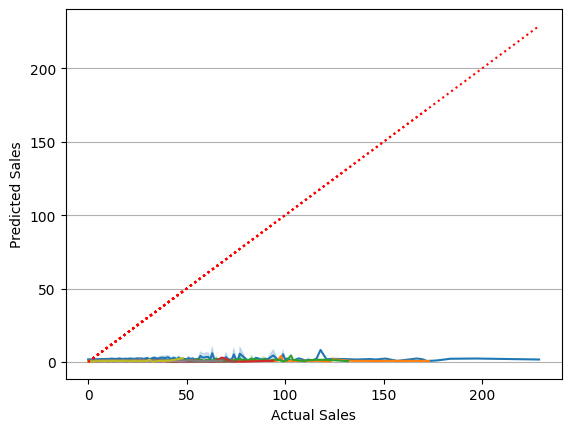

In [32]:
# print("Data file:", file)
print("Data shape:", data_test.shape)

selected_ids = [c for c in id_cols if c not in ["id"]]
os.makedirs(output_folder, exist_ok=True)

for model_path in model_paths:
    state, cat_id = model_path.split("_")[1:3]

    # Load data
    df_val = get_input_data(
        data=data_test,
        prices=prices,
        calendar=calendar,
        state_id=state,
        cat_id=cat_id,
        # item_id=selected_item,
        drop_columns=[],
    )
    df_val = prepare_datasets(df_val)
    df_val = reduce_mem_usage(df_val)
    # print("Data for validation:", df_val.shape)
    # df_val.head()

    # Load Model
    model = joblib.load(model_path)
    df_val["sales_predicted"] = model.predict(df_val)

    # Assess Predictions
    y_val = df_val["sales"]
    y_val_pred = df_val["sales_predicted"]

    plot_actual_vs_pred(y_val, y_val_pred)
    model_metrics = compute_metrics(y_val, y_val_pred)
    pd.DataFrame({"TestValidation": model_metrics}).T

    # Create submission part
    submission_part = compute_submission(df_val=df_val, selected_ids=selected_ids)
    test_volume(submission=submission_part, df_val=df_val)
    print(submission_part.shape)
    file_path = os.path.join(output_folder, f"{state}_{cat_id}_part.parquet")
    submission_part.to_parquet(file_path, index=False)
    print(f"File {file_path} created!")

# Create Submission


In [33]:
import glob

# Obtener todos los archivos Parquet de la carpeta
parquet_files = glob.glob(os.path.join(output_folder, "*.parquet"))

# Leer y concatenar todos los DataFrames
dataframes = [pd.read_parquet(file) for file in parquet_files]
submission = pd.concat(dataframes, ignore_index=True)
print(submission.shape)
display(submission)

,item_id,dept_id,cat_id,store_id,state_id,d_1942,d_1943,d_1944,d_1945,d_1946,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_2,TX,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_3,TX,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
3,HOBBIES_1_002,HOBBIES_1,HOBBIES,TX_1,TX,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,HOBBIES_1_002,HOBBIES_1,HOBBIES,TX_2,TX,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_826,FOODS_3,FOODS,WI_2,WI,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0
30486,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
30487,FOODS_3_827,FOODS_3,FOODS,WI_1,WI,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0
30488,FOODS_3_827,FOODS_3,FOODS,WI_2,WI,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0
